# Explore differences in aromatic amino acid genes

This notebook compares the expression activity of genes related to the aromatic amino acid pathway between PAO1 and PA14 strains using both RNA-seq and array compendia. The goal is to determine if the differences in expression activity between PAO1 vs PA14 are consistent using both RNA-seq and array compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import json
import pandas as pd
from scripts import paths

## Load expression compendia

In [2]:
# RNA-seq compendia files
rnaseq_pao1_compendium_filename = paths.PAO1_COMPENDIUM
rnaseq_pa14_compendium_filename = paths.PA14_COMPENDIUM

# Array compendia files
array_pao1_compendium_filename = paths.PAO1_COMPENDIUM_ARRAY
array_pa14_compendium_filename = paths.PA14_COMPENDIUM_ARRAY

In [3]:
# Load expression data
rnaseq_pao1_compendium = pd.read_csv(
    rnaseq_pao1_compendium_filename, sep="\t", index_col=0, header=0
)
rnaseq_pa14_compendium = pd.read_csv(
    rnaseq_pa14_compendium_filename, sep="\t", index_col=0, header=0
)

array_pao1_compendium = pd.read_csv(
    array_pao1_compendium_filename, sep="\t", index_col=0, header=0
)
array_pa14_compendium = pd.read_csv(
    array_pa14_compendium_filename, sep="\t", index_col=0, header=0
)

## Load KEGG pathways

In [4]:
# Load KEGG pathway data
pao1_pathway_filename = "../3_core_core_analysis/pao1_kegg_annot.tsv"
pa14_pathway_filename = "../3_core_core_analysis/pa14_kegg_annot.tsv"

In [5]:
pao1_pathways = pd.read_csv(pao1_pathway_filename, sep="\t", header=0, index_col=0)
pa14_pathways = pd.read_csv(pa14_pathway_filename, sep="\t", header=0, index_col=0)

In [6]:
print(pao1_pathways.shape)
pao1_pathways.head()

(123, 3)


,pathway_name,num_genes,gene_ids
pathway_id_name,,,
path:pae00010 : Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,37,"['PA3193', 'PA4732', 'PA5110', 'PA0555', 'PA47..."
path:pae00020 : Citrate cycle (TCA cycle),Citrate cycle (TCA cycle),28,"['PA1580', 'PA1562', 'PA1787', 'PA2623', 'PA26..."
path:pae00030 : Pentose phosphate pathway,Pentose phosphate pathway,28,"['PA4732', 'PA5439', 'PA3183', 'PA3182', 'PA42..."
path:pae00040 : Pentose and glucuronate interconversions,Pentose and glucuronate interconversions,8,"['PA2022', 'PA3559', 'PA2023', 'PA0607', 'PA23..."
path:pae00051 : Fructose and mannose metabolism,Fructose and mannose metabolism,19,"['PA2344', 'PA3551', 'PA2232', 'PA5452', 'PA53..."


In [7]:
print(pa14_pathways.shape)
pa14_pathways.head()

(123, 3)


,pathway_name,num_genes,gene_ids
pathway_id_name,,,
path:pau00010 : Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,37,"['PA14_22930', 'PA14_62620', 'PA14_67490', 'PA..."
path:pau00020 : Citrate cycle (TCA cycle),Citrate cycle (TCA cycle),28,"['PA14_44070', 'PA14_44290', 'PA14_41470', 'PA..."
path:pau00030 : Pentose phosphate pathway,Pentose phosphate pathway,28,"['PA14_62620', 'PA14_71800', 'PA14_23070', 'PA..."
path:pau00040 : Pentose and glucuronate interconversions,Pentose and glucuronate interconversions,8,"['PA14_38360', 'PA14_18300', 'PA14_38350', 'PA..."
path:pau00051 : Fructose and mannose metabolism,Fructose and mannose metabolism,18,"['PA14_34340', 'PA14_18380', 'PA14_71970', 'PA..."


## Get aromatic amino acid genes

In [8]:
# Aromatic amino acid pathways
# Are there others to include?
# https://docs.google.com/spreadsheets/d/1pDehBGTyCN0hTrlvbBNymeI640Sl68XlUBwBU8aPZTA/edit#gid=2100140648
pao1_aa_pathways = [
    "path:pae00362 : Benzoate degradation",
    "path:pae00350 : Tyrosine metabolism",
    "path:pae00620 : Pyruvate metabolism",
    "path:pae01220 : Degradation of aromatic compounds",
]

pa14_aa_pathways = [
    "path:pau00362 : Benzoate degradation",
    "path:pau00350 : Tyrosine metabolism",
    "path:pau00620 : Pyruvate metabolism",
    "path:pau01220 : Degradation of aromatic compounds",
]

In [9]:
# Select associated gene sets
def get_associated_genes(pathway_db, selected_pathways):
    aa_genes = set()
    for gene_set in pathway_db.loc[selected_pathways, "gene_ids"]:
        gene_set_processed = set(json.loads(gene_set.replace("'", '"')))
        aa_genes = aa_genes.union(gene_set_processed)

    return list(aa_genes)

In [10]:
pao1_aa_genes = get_associated_genes(pao1_pathways, pao1_aa_pathways)
print(pao1_aa_genes, len(pao1_aa_genes))

['PA3226', 'PA1017', 'PA2250', 'PA4829', 'PA1984', 'PA3590', 'PA0854', 'PA2266', 'PA1027', 'PA1813', 'PA4124', 'PA4486', 'PA0228', 'PA3524', 'PA3014', 'PA2517', 'PA0482', 'PA1587', 'PA4092', 'PA4470', 'PA0836', 'PA5192', 'PA4733', 'PA5111', 'PA0231', 'PA4128', 'PA0421', 'PA0887', 'PA1736', 'PA3471', 'PA4899', 'PA4022', 'PA3426', 'PA4152', 'PA0480', 'PA1982', 'PA5015', 'PA4848', 'PA2518', 'PA5046', 'PA3639', 'PA4073', 'PA1135', 'PA3687', 'PA2275', 'PA4333', 'PA0870', 'PA3896', 'PA4123', 'PA2516', 'PA3454', 'PA4121', 'PA2555', 'PA4447', 'PA4771', 'PA4772', 'PA4091', 'PA0832', 'PA2508', 'PA2108', 'PA1737', 'PA3013', 'PA0927', 'PA1770', 'PA2470', 'PA5427', 'PA0493', 'PA1629', 'PA0954', 'PA5297', 'PA0968', 'PA1748', 'PA1821', 'PA4872', 'PA2008', 'PA0153', 'PA5445', 'PA5436', 'PA2509', 'PA0242', 'PA0865', 'PA3629', 'PA3452', 'PA0230', 'PA3112', 'PA2515', 'PA0232', 'PA2001', 'PA2507', 'PA0247', 'PA2471', 'PA1628', 'PA0835', 'PA3925', 'PA0265', 'PA2940', 'PA4329', 'PA4847', 'PA2531', 'PA0710',

In [11]:
pa14_aa_genes = get_associated_genes(pa14_pathways, pa14_aa_pathways)
print(pa14_aa_genes, len(pa14_aa_genes))

['PA14_19190', 'PA14_40980', 'PA14_68580', 'PA14_32130', 'PA14_26010', 'PA14_02840', 'PA14_15030', 'PA14_63250', 'PA14_43970', 'PA14_38860', 'PA14_64440', 'PA14_06290', 'PA14_25080', 'PA14_41670', 'PA14_31530', 'PA14_10590', 'PA14_71630', 'PA14_66310', 'PA14_38840', 'PA14_10990', 'PA14_35270', 'PA14_38550', 'PA14_53010', 'PA14_01900', 'PA14_42090', 'PA14_41080', 'PA14_17270', 'PA14_11000', 'PA14_06430', 'PA14_17400', 'PA14_19470', 'PA14_58030', 'PA14_32650', 'PA14_16690', 'PA14_63100', 'PA14_32110', 'PA14_62630', 'PA14_06450', 'PA14_11190', 'PA14_53220', 'PA14_02850', 'PA14_10640', 'PA14_35490', 'PA14_52800', 'PA14_01910', 'PA14_66680', 'PA14_56300', 'PA14_55130', 'PA14_32230', 'PA14_64740', 'PA14_03000', 'PA14_64110', 'PA14_10610', 'PA14_51050', 'PA14_13500', 'PA14_10240', 'PA14_11810', 'PA14_63090', 'PA14_57770', 'PA14_51920', 'PA14_63850', 'PA14_71720', 'PA14_33860', 'PA14_23500', 'PA14_02830', 'PA14_19740', 'PA14_31500', 'PA14_17860', 'PA14_25090', 'PA14_53510', 'PA14_05840', 'PA14

## Get expression activity of aromatic amino acid genes

In [12]:
# Select rna-seq genes that are related to AA pathways
rnaseq_pao1_aa_expression = rnaseq_pao1_compendium[pao1_aa_genes]
rnaseq_pa14_aa_expression = rnaseq_pa14_compendium[pa14_aa_genes]

rnaseq_pao1_aa_expression.head()

,PA3226,PA1017,PA2250,PA4829,PA1984,PA3590,PA0854,PA2266,PA1027,PA1813,...,PA2009,PA2007,PA3139,PA3165,PA0154,PA5435,PA5016,PA4127,PA1217,PA3792
ERX541571,380.917417,55.132784,1413.404098,330.796704,5.012071,60.144855,395.953630,330.796704,32.578463,70.168998,...,370.893274,200.482851,1528.681737,448.580379,32.578463,731.762405,436.050200,17.542249,60.144855,320.772561
ERX541572,303.934734,48.453363,1339.074768,295.125031,7.341419,58.731349,480.128782,167.384346,22.024256,70.477619,...,509.494457,283.378761,1521.141951,418.460865,24.960824,477.192214,450.763107,27.897391,92.501875,233.457114
ERX541573,140.644956,92.010719,1895.420804,119.613934,6.572194,73.608575,625.672887,107.783985,23.659899,70.979697,...,778.147792,383.816141,1436.681649,449.538082,42.062043,1100.185307,563.894261,39.433165,106.469546,423.249306
ERX541574,216.600523,85.688119,1742.325083,140.433306,38.083608,88.068344,625.999313,92.828795,40.463834,95.209021,...,864.021865,354.653603,1125.846673,366.554731,52.364962,1190.112762,771.193070,30.942932,102.349698,421.299918
ERX541575,132.398068,55.330536,946.547380,94.852347,9.880453,53.354445,543.424905,138.326339,25.689177,86.947985,...,482.166097,306.294037,1019.662730,373.481116,49.402264,944.571289,628.396799,25.689177,116.589343,383.361569


In [14]:
# Select array genes that are related to AA pathways
shared_pao1_aa_genes = set(pao1_aa_genes).intersection(array_pao1_compendium.columns)
array_pao1_aa_expression = array_pao1_compendium[shared_pao1_aa_genes]
array_pa14_aa_expression = array_pa14_compendium[shared_pao1_aa_genes]

array_pao1_aa_expression.head()

,PA3226,PA1984,PA0854,PA2266,PA1027,PA4124,PA0228,PA2517,PA0836,PA5192,...,PA2382,PA4640,PA4122,PA1498,PA0447,PA4125,PA2009,PA2007,PA4127,PA1217
GSM92174.CEL,7.435273,11.264071,9.441087,6.095651,7.527532,6.357438,5.993891,5.855233,9.184667,9.459215,...,6.640453,9.530207,6.724334,5.897372,10.190707,5.850938,11.609192,11.097755,5.820213,7.575525
GSM629178.CEL,6.951654,9.291225,8.124462,7.595058,6.517399,5.719590,5.970415,6.308576,10.047936,11.122368,...,6.571567,9.752692,6.759864,5.957895,7.888101,5.899503,8.592038,7.525897,5.616565,5.974559
MBU_JGOLD_pakA1.CEL,8.641465,8.683847,8.982144,8.988543,7.223027,5.743715,5.730533,6.085422,8.955857,7.925593,...,6.101220,7.992762,7.118185,6.698049,7.767961,5.721639,7.095766,7.356634,5.764248,8.233182
GSM838206_OXYR-LB-1_Pae_G1a.CEL,6.875030,8.757921,8.412259,6.612961,7.297092,5.809898,6.263723,5.891293,9.261823,9.450347,...,6.068757,9.112787,6.831301,5.836923,10.670299,5.779466,10.597141,9.634626,6.144811,7.346786
GSM267248.CEL,6.672580,8.305613,7.487909,6.987447,6.962826,6.220918,6.486583,6.687925,10.386336,10.256900,...,6.626859,7.339937,7.585963,6.451791,7.820443,6.473380,6.780304,6.289794,5.866177,6.151821


In [15]:
# Calculate median across samples
rnaseq_pao1_aa_expression_median = rnaseq_pao1_aa_expression.median()
rnaseq_pa14_aa_expression_median = rnaseq_pa14_aa_expression.median()

array_pao1_aa_expression_median = array_pao1_aa_expression.median()
array_pa14_aa_expression_median = array_pa14_aa_expression.median()

In [18]:
# Calculate difference in median of medians
diff_rnaseq = abs(
    rnaseq_pao1_aa_expression_median.median()
    - rnaseq_pa14_aa_expression_median.median()
)
diff_rnaseq

38.512788560844484

In [19]:
diff_array = abs(
    array_pao1_aa_expression_median.median() - array_pa14_aa_expression_median.median()
)
diff_array

0.037075178674999876

## Plot

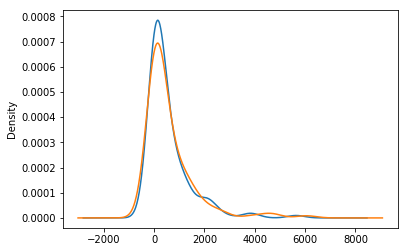

In [26]:
# Plot box plot of rna-seq and array
rnaseq_pao1_aa_expression_median.plot(kind="density")
rnaseq_pa14_aa_expression_median.plot(kind="density")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


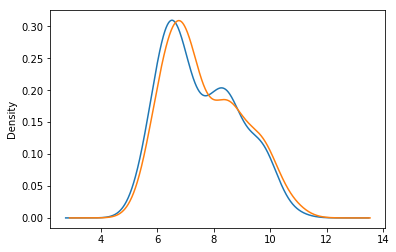

In [25]:
array_pao1_aa_expression_median.plot(kind="density")
array_pa14_aa_expression_median.plot(kind="density")